In [71]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

from pandas import read_csv
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import alpha_vantage
from alpha_vantage.timeseries import TimeSeries 

print("All libraries loaded")


All libraries loaded


In [72]:
config = {
    "alpha_vantage": {
        "key": "KNKL5W59B6K6W1LD",
        "symbol": "AAPL",
        "outputsize": "full",
        "key_adjusted_close": "4. close",
    },
    "data": {
        "window_size": 30,
        "train_split_size": 0.9,
    }, 
    "plots": {
        "xticks_interval": 500, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 10,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    },
    "csv":{
        "file_name": "AAPL.csv",
    }
}

config_rand = []

for i in range(100):
    config_rand += [float(random.randrange(0,100))]


In [73]:
# loading data from Alpha Advantage API
'''
def download_data(config):
    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)
    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config)
'''

# loading data from local csv files
def download_data(config):
    stock_data = np.matrix(read_csv("BTC-USD.csv"))
    data_date = np.array(stock_data[:, 0])
    data_close_price = np.array(stock_data[:, 5])

    data_date = [elem[0] for elem in data_date]
    date_close_price = [float(elem[0]) for elem in data_close_price]
    data_close_price = np.array(date_close_price)

    #data_date = data_date[::-1]
    #data_close_price = data_close_price[::-1]

    cut_off = 1826
    data_date = data_date[:cut_off]
    data_close_price = data_close_price[:cut_off]

   #data_date = np.arange(len(data_date))

    num_data_points = len(data_date)
    display_date_range = "from " + str(data_date[0]) + " to " + str(data_date[num_data_points-1])
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range


data_date, data_close_price, num_data_points, display_date_range = download_data(config)

print(data_close_price)
'''
#Self Made data in the form of n = x * average(n-k : n) + y * average(n - k : n)

def generate_data(k, x, y, z):
    data_date = np.arange(10000)
    data = []
    for i in range(k):
        data += [float(random.randrange(0,100))]
    print(data)
    while len(data) < 10000:
        temp_data_1 = data[len(data) - k:]
        temp_data_2 = data[len(data) - 10:]
        data += [x * np.mean(temp_data_1) + y * np.std(temp_data_1) + z * np.mean(temp_data_2)] 
    num_data_points = len(data)
    display_date_range = "from 0 to 9999"
    return data_date, data, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = generate_data(30, 0.1, 2.25, 0.3)
print(data_close_price)
'''
'''
def generate_data():
    data_date = np.arange(10000)
    data = []
    for i in range(10000):
        data += [ np.cos(i) * np.sin(i) * (i % 100)]
    num_data_points = len(data)
    display_date_range = "from 0 to 9999"
    return data_date, data, num_data_points, display_date_range

def generate_random(k, config_rand):
    rand = []
    while len(rand) < 10000:
        rand += [ config_rand[len(rand) % k] ]
    data_date = np.arange(10000)
    num_data_points = len(rand)
    display_date_range = "from 0 to 9999"
    return data_date, rand, num_data_points, display_date_range

def generate_brownian_motion():
    rand = np.random.normal(0, 1, 10000)
    data_date = np.arange(10000)
    num_data_points = len(rand)
    display_date_range = "from 0 to 9999"
    return data_date, rand, num_data_points, display_date_range


data_date, data_close_price, num_data_points, display_date_range = generate_brownian_motion()
'''

# plot
'''
fig = figure(figsize=(40, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.show()
'''


Number data points 1826 from 2019-07-03 to 2024-07-01
[11961.269531 11215.4375   10978.459961 ... 60887.378906 62678.292969
 62851.980469]


'\nfig = figure(figsize=(40, 5), dpi=80)\nfig.patch.set_facecolor((1.0, 1.0, 1.0))\nplt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])\nxticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice\nx = np.arange(0,len(xticks))\nplt.xticks(x, xticks, rotation=\'vertical\')\nplt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)\nplt.show()\n'

In [74]:

class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x
    
    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)
print(normalized_data_close_price)

"""
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, normalized_data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.show()
"""



[-1.00038075 -1.04172295 -1.05485884 ...  1.71164138  1.8109135
  1.82054117]


'\nfig = figure(figsize=(25, 5), dpi=80)\nfig.patch.set_facecolor((1.0, 1.0, 1.0))\nplt.plot(data_date, normalized_data_close_price, color=config["plots"]["color_actual"])\nxticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice\nx = np.arange(0,len(xticks))\nplt.xticks(x, xticks, rotation=\'vertical\')\nplt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)\nplt.show()\n'

In [75]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]


def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

# split dataset

split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

# prepare data for plotting

to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)

to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)


## plots
'''
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
plt.legend()
plt.show()'''


'\nfig = figure(figsize=(25, 5), dpi=80)\nfig.patch.set_facecolor((1.0, 1.0, 1.0))\nplt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])\nplt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])\nxticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice\nx = np.arange(0,len(xticks))\nplt.xticks(x, xticks, rotation=\'vertical\')\nplt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")\nplt.legend()\nplt.show()'

In [76]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

Train data shape (1616, 30, 1) (1616,)
Validation data shape (180, 30, 1) (180,)


In [77]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

In [78]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

loss_list_25th = []
loss_train_list = []
loss_val_list = []
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    optimizer.step()
    #scheduler.step()
    print('Epoch[{}/{}] | loss train:{:.10f}, test:{:.10f} | lr:{:.10f}'
                .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))
    loss_train_list += [loss_train]
    loss_val_list += [loss_val]
    if ((epoch+1) % 25) == 0 or epoch == 0: 
        loss_list_25th += [loss_train]
        loss_list_25th += [loss_val]
print(loss_list_25th)


Epoch[1/10] | loss train:0.0358505520, test:0.0022148637 | lr:0.0100000000
Epoch[2/10] | loss train:0.0028679564, test:0.0017345224 | lr:0.0100000000
Epoch[3/10] | loss train:0.0024945884, test:0.0011121202 | lr:0.0100000000
Epoch[4/10] | loss train:0.0026571504, test:0.0026717178 | lr:0.0100000000
Epoch[5/10] | loss train:0.0020537513, test:0.0011954549 | lr:0.0100000000
Epoch[6/10] | loss train:0.0020884971, test:0.0009710905 | lr:0.0100000000
Epoch[7/10] | loss train:0.0023374153, test:0.0014803295 | lr:0.0100000000
Epoch[8/10] | loss train:0.0023232971, test:0.0019997649 | lr:0.0100000000
Epoch[9/10] | loss train:0.0026225635, test:0.0015846299 | lr:0.0100000000
Epoch[10/10] | loss train:0.0033090339, test:0.0009795308 | lr:0.0100000000
[0.03585055204166565, 0.0022148636769718276]


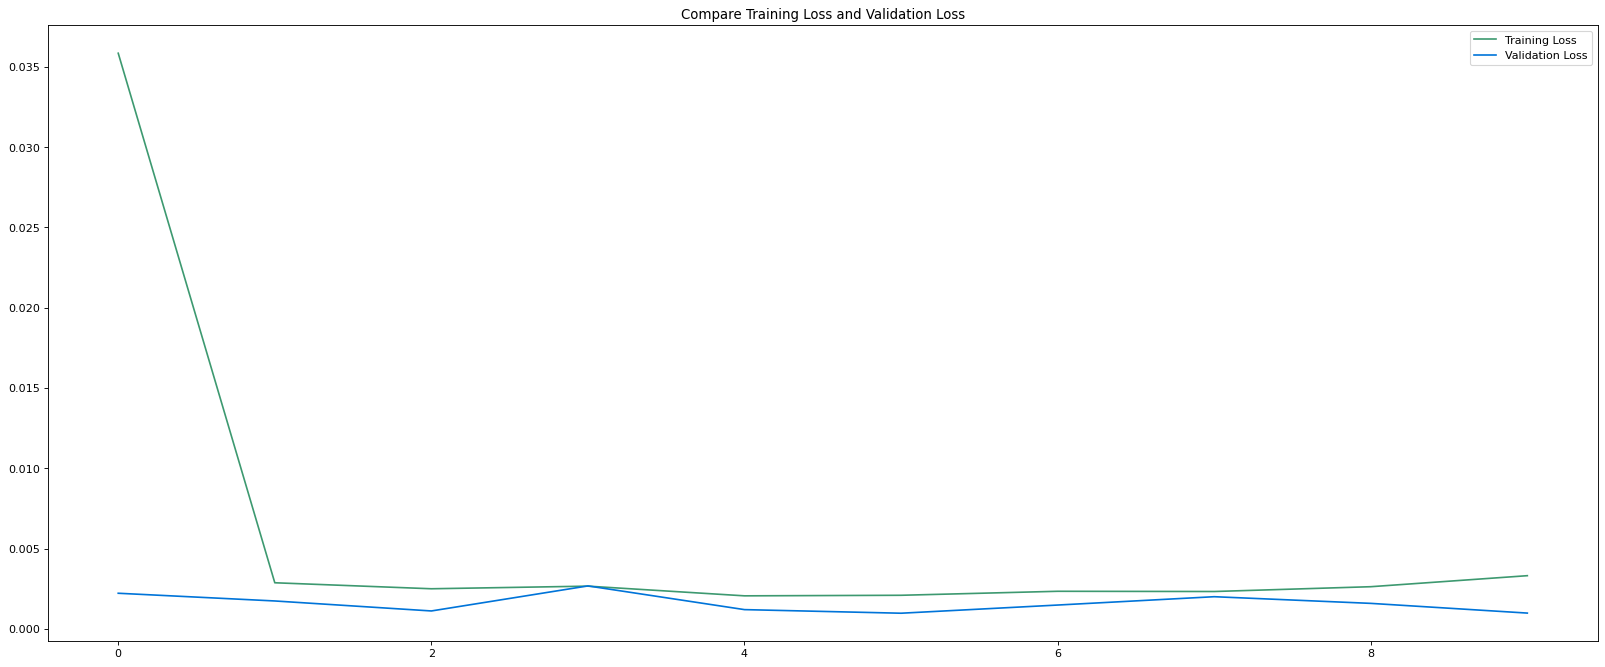

In [79]:
epoch_list = np.arange(config["training"]["num_epoch"])

fig = figure(figsize=(25, 10), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(epoch_list, loss_train_list, label="Training Loss", color=config["plots"]["color_pred_train"])
plt.plot(epoch_list, loss_val_list, label="Validation Loss", color=config["plots"]["color_pred_val"])
plt.title("Compare Training Loss and Validation Loss")
plt.legend()
plt.show()

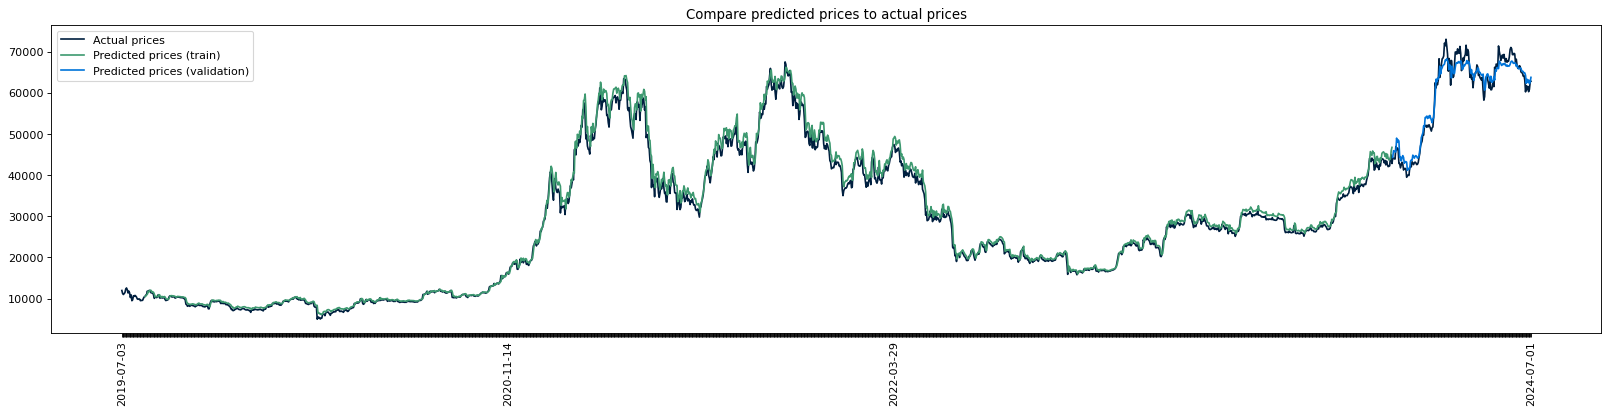

In [80]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

# prepare data for plotting

to_plot_data_y_train_pred = np.zeros(num_data_points)
to_plot_data_y_val_pred = np.zeros(num_data_points)

to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Compare predicted prices to actual prices")
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.legend()
plt.show()

In [81]:
"""
# prepare data for plotting the zoomed in view of the predicted prices (on validation set) vs. actual prices

to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
to_plot_predicted_val = scaler.inverse_transform(predicted_val)
to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Zoom in to examine predicted price on validation data portion")
xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
xs = np.arange(0,len(xticks))
plt.xticks(xs, xticks, rotation='vertical')
plt.legend()
plt.show()
"""

'\n# prepare data for plotting the zoomed in view of the predicted prices (on validation set) vs. actual prices\n\nto_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)\nto_plot_predicted_val = scaler.inverse_transform(predicted_val)\nto_plot_data_date = data_date[split_index+config["data"]["window_size"]:]\n\n# plots\n\nfig = figure(figsize=(25, 5), dpi=80)\nfig.patch.set_facecolor((1.0, 1.0, 1.0))\nplt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])\nplt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])\nplt.title("Zoom in to examine predicted price on validation data portion")\nxticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice\nxs

/var/folders/k4/kjr_rgdn28zfgt5smpzd7xg80000gn/T/ipykernel_2003/1630144636.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  to_plot_data_y_test_pred[plot_range-1] = scaler.inverse_transform(prediction)


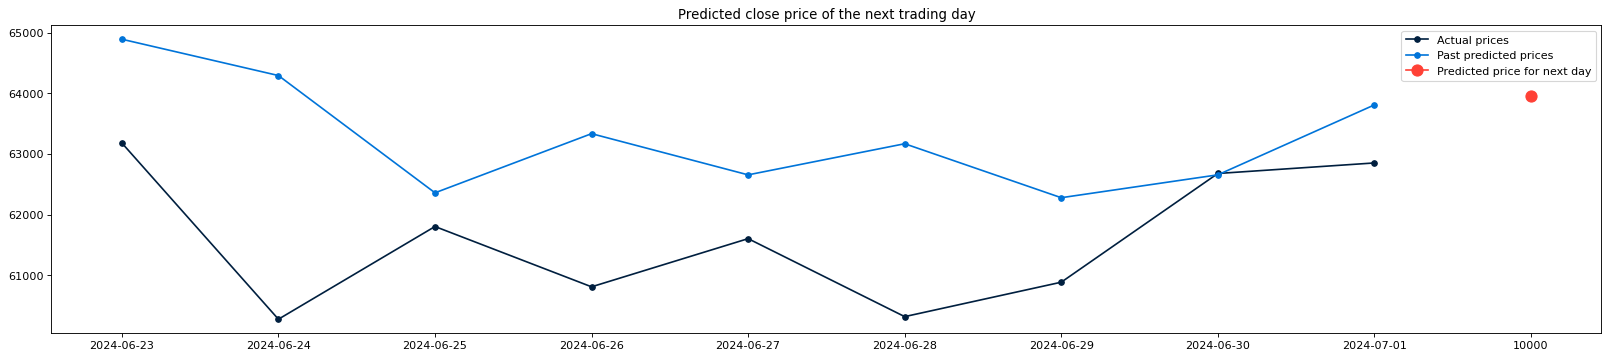

Predicted close price of the next trading day: 63956.36


In [82]:
# predict the closing price of the next trading day

model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()

# prepare plots

plot_range = 10
to_plot_data_y_val = np.zeros(plot_range)
to_plot_data_y_val_pred = np.zeros(plot_range)
to_plot_data_y_test_pred = np.zeros(plot_range)

to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

to_plot_data_y_test_pred[plot_range-1] = scaler.inverse_transform(prediction)

to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

# plot

plot_date_test = data_date[-plot_range+1:]
plot_date_test += [10000]

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
plt.title("Predicted close price of the next trading day")
plt.legend()
plt.show()

print("Predicted close price of the next trading day:", round(to_plot_data_y_test_pred[plot_range-1], 2))


BTC data:
1:
[0.035748502855906535, 0.0013317543180627104, 0.0014516162618684171, 0.0005150965788728218, 0.0009948918109251457, 0.00034604111675758695, 0.001020873152100421, 0.00031549306461753167, 0.0009509156934781357, 0.0003176365131420718, 0.0009439931826622998, 0.0003100294542668885, 0.0009407295578651227, 0.0003105418814441892, 0.0009416977568434959, 0.00031155786014404823, 0.0009397351881072306, 0.00031131575010708034, 0.0009544009931248512, 0.00031129439715233136, 0.0009419884367218856, 0.0003117599330912295, 0.0009451566184945174, 0.00031160261779651763, 0.0009405772475995869, 0.00031134759920490267]

2 (20000:) : 
[0.05968301597431491, 0.00016298538154186707, 0.0019018103471353243, 0.0001593711868672683, 0.0025678684123704443, 0.00022807314588473758, 0.0020026855922878894, 0.0001825303904064809, 0.004028024348372128, 0.00017372169808960427, 0.0017555411632201867, 0.00013073165645923732, 0.0020017015390294546, 0.0001318565076988222, 0.001768903531228716, 0.00012660927980103352, 0.0021421349701995496, 0.00012983895784558162]



EURUSD Training Result:

Epoch[1/200] | loss train:0.0691478338, test:0.0008225897 | lr:0.0100000000
Epoch[2/200] | loss train:0.0121363931, test:0.0019171984 | lr:0.0100000000
Epoch[3/200] | loss train:0.0108834945, test:0.0016067017 | lr:0.0100000000
Epoch[4/200] | loss train:0.0101326545, test:0.0009872033 | lr:0.0100000000
Epoch[5/200] | loss train:0.0099313373, test:0.0008735673 | lr:0.0100000000
Epoch[6/200] | loss train:0.0095488712, test:0.0009523329 | lr:0.0100000000
Epoch[7/200] | loss train:0.0091961821, test:0.0015243408 | lr:0.0100000000
Epoch[8/200] | loss train:0.0087783801, test:0.0006284363 | lr:0.0100000000
Epoch[9/200] | loss train:0.0088686504, test:0.0008105492 | lr:0.0100000000
Epoch[10/200] | loss train:0.0086075023, test:0.0008033224 | lr:0.0100000000
Epoch[11/200] | loss train:0.0084885117, test:0.0005660224 | lr:0.0100000000
Epoch[12/200] | loss train:0.0084810443, test:0.0005547841 | lr:0.0100000000
Epoch[13/200] | loss train:0.0083455516, test:0.0005748897 | lr:0.0100000000
Epoch[14/200] | loss train:0.0083025858, test:0.0012779039 | lr:0.0100000000
Epoch[15/200] | loss train:0.0082893773, test:0.0006374619 | lr:0.0100000000
Epoch[16/200] | loss train:0.0082760242, test:0.0005773010 | lr:0.0100000000
Epoch[17/200] | loss train:0.0081361944, test:0.0006015444 | lr:0.0100000000
Epoch[18/200] | loss train:0.0081595028, test:0.0006038448 | lr:0.0100000000
Epoch[19/200] | loss train:0.0080481429, test:0.0010185691 | lr:0.0100000000
Epoch[20/200] | loss train:0.0082025099, test:0.0005598815 | lr:0.0100000000
Epoch[21/200] | loss train:0.0078673466, test:0.0005549175 | lr:0.0100000000
Epoch[22/200] | loss train:0.0077841952, test:0.0016486956 | lr:0.0100000000
Epoch[23/200] | loss train:0.0076949997, test:0.0007061665 | lr:0.0100000000
Epoch[24/200] | loss train:0.0077763664, test:0.0005996768 | lr:0.0100000000
Epoch[25/200] | loss train:0.0089865327, test:0.0009187112 | lr:0.0100000000
Epoch[26/200] | loss train:0.0075343586, test:0.0008021840 | lr:0.0100000000
Epoch[27/200] | loss train:0.0074498159, test:0.0006711773 | lr:0.0100000000
Epoch[28/200] | loss train:0.0074393469, test:0.0007977107 | lr:0.0100000000
Epoch[29/200] | loss train:0.0074208707, test:0.0005355134 | lr:0.0100000000
Epoch[30/200] | loss train:0.0087284285, test:0.0006435892 | lr:0.0100000000
Epoch[31/200] | loss train:0.0076029928, test:0.0006135401 | lr:0.0100000000
Epoch[32/200] | loss train:0.0093676724, test:0.0006499860 | lr:0.0100000000
Epoch[33/200] | loss train:0.0072544497, test:0.0013414127 | lr:0.0100000000
Epoch[34/200] | loss train:0.0072712576, test:0.0006018376 | lr:0.0100000000
Epoch[35/200] | loss train:0.0072372629, test:0.0006417232 | lr:0.0100000000
Epoch[36/200] | loss train:0.0072394985, test:0.0005530682 | lr:0.0100000000
Epoch[37/200] | loss train:0.0072306977, test:0.0007263525 | lr:0.0100000000
Epoch[38/200] | loss train:0.0072053223, test:0.0005996213 | lr:0.0100000000
Epoch[39/200] | loss train:0.0071938862, test:0.0008047110 | lr:0.0100000000
Epoch[40/200] | loss train:0.0071633845, test:0.0006565568 | lr:0.0100000000
Epoch[41/200] | loss train:0.0071630892, test:0.0005655575 | lr:0.0100000000
Epoch[42/200] | loss train:0.1668521549, test:0.0356150686 | lr:0.0100000000
Epoch[43/200] | loss train:0.0592821172, test:0.0006087026 | lr:0.0100000000
Epoch[44/200] | loss train:0.0320418914, test:0.0009675318 | lr:0.0100000000
Epoch[45/200] | loss train:0.0620356254, test:0.0014246840 | lr:0.0100000000
Epoch[46/200] | loss train:0.0306725641, test:0.0020914362 | lr:0.0100000000
Epoch[47/200] | loss train:0.0386282917, test:0.0047935866 | lr:0.0100000000
Epoch[48/200] | loss train:0.1180655597, test:0.0032653512 | lr:0.0100000000
Epoch[49/200] | loss train:0.0461672245, test:0.0016642454 | lr:0.0100000000
Epoch[50/200] | loss train:0.1425239238, test:0.0015630895 | lr:0.0100000000
Epoch[51/200] | loss train:0.5641489720, test:0.0052082294 | lr:0.0100000000
Epoch[52/200] | loss train:0.0176589261, test:0.0017862645 | lr:0.0100000000
Epoch[53/200] | loss train:0.0139333850, test:0.0010109902 | lr:0.0100000000
Epoch[54/200] | loss train:0.0181258454, test:0.0013177112 | lr:0.0100000000
Epoch[55/200] | loss train:0.0185439830, test:0.0006670062 | lr:0.0100000000
Epoch[56/200] | loss train:0.0081442410, test:0.0019733098 | lr:0.0100000000
Epoch[57/200] | loss train:0.0078772227, test:0.0007010140 | lr:0.0100000000
Epoch[58/200] | loss train:0.0078649844, test:0.0005738960 | lr:0.0100000000
Epoch[59/200] | loss train:0.0078743448, test:0.0008755627 | lr:0.0100000000
Epoch[60/200] | loss train:0.0077836754, test:0.0005466843 | lr:0.0100000000
Epoch[61/200] | loss train:0.0076957065, test:0.0010310015 | lr:0.0100000000
Epoch[62/200] | loss train:0.0077218505, test:0.0063900611 | lr:0.0100000000
Epoch[63/200] | loss train:0.0076406288, test:0.0006715978 | lr:0.0100000000
Epoch[64/200] | loss train:0.0075840946, test:0.0005301981 | lr:0.0100000000
Epoch[65/200] | loss train:0.0076906551, test:0.0006470485 | lr:0.0100000000
Epoch[66/200] | loss train:0.0075438118, test:0.0007442750 | lr:0.0100000000
Epoch[67/200] | loss train:0.0076599096, test:0.0007162794 | lr:0.0100000000
Epoch[68/200] | loss train:0.0081364659, test:0.0005172303 | lr:0.0100000000
Epoch[69/200] | loss train:0.0074693955, test:0.0005416838 | lr:0.0100000000
Epoch[70/200] | loss train:0.0075482144, test:0.0007603651 | lr:0.0100000000
Epoch[71/200] | loss train:0.0075292851, test:0.0005637602 | lr:0.0100000000
Epoch[72/200] | loss train:0.0074857459, test:0.0006187948 | lr:0.0100000000
Epoch[73/200] | loss train:0.0074902961, test:0.0006330680 | lr:0.0100000000
Epoch[74/200] | loss train:0.0073694094, test:0.0006200033 | lr:0.0100000000
Epoch[75/200] | loss train:0.0075631800, test:0.0008135880 | lr:0.0100000000
Epoch[76/200] | loss train:0.0073553186, test:0.0005446316 | lr:0.0100000000
Epoch[77/200] | loss train:0.0073379455, test:0.0010424586 | lr:0.0100000000
Epoch[78/200] | loss train:0.0072878935, test:0.0006814548 | lr:0.0100000000
Epoch[79/200] | loss train:0.0073512259, test:0.0005219196 | lr:0.0100000000
Epoch[80/200] | loss train:0.0073379457, test:0.0005558269 | lr:0.0100000000
Epoch[81/200] | loss train:0.0072425181, test:0.0008059503 | lr:0.0100000000
Epoch[82/200] | loss train:0.0073079224, test:0.0005549689 | lr:0.0100000000
Epoch[83/200] | loss train:0.0072473656, test:0.0006000948 | lr:0.0100000000
Epoch[84/200] | loss train:0.0073109217, test:0.0010937006 | lr:0.0100000000
Epoch[85/200] | loss train:0.0073235298, test:0.0009563906 | lr:0.0100000000
Epoch[86/200] | loss train:0.0073272635, test:0.0006063098 | lr:0.0100000000
Epoch[87/200] | loss train:0.0073037784, test:0.0005434367 | lr:0.0100000000
Epoch[88/200] | loss train:0.0072436007, test:0.0005304329 | lr:0.0100000000
Epoch[89/200] | loss train:0.0072952974, test:0.0005522231 | lr:0.0100000000
Epoch[90/200] | loss train:0.0071997609, test:0.0006423579 | lr:0.0100000000
Epoch[91/200] | loss train:0.0078483668, test:0.0005297679 | lr:0.0100000000
Epoch[92/200] | loss train:0.0102535906, test:0.0005562321 | lr:0.0100000000
Epoch[93/200] | loss train:0.0077798502, test:0.0007535135 | lr:0.0100000000
Epoch[94/200] | loss train:0.0072385519, test:0.0005700273 | lr:0.0100000000
Epoch[95/200] | loss train:0.0073096208, test:0.0005795087 | lr:0.0100000000
Epoch[96/200] | loss train:0.0076941084, test:0.0005487937 | lr:0.0100000000
Epoch[97/200] | loss train:0.0073498899, test:0.0005508804 | lr:0.0100000000
Epoch[98/200] | loss train:0.0074106346, test:0.0014873801 | lr:0.0100000000
Epoch[99/200] | loss train:0.0076005040, test:0.0005560084 | lr:0.0100000000
Epoch[100/200] | loss train:0.0074267981, test:0.0007165476 | lr:0.0100000000
Epoch[101/200] | loss train:0.0072842901, test:0.0005335283 | lr:0.0100000000
Epoch[102/200] | loss train:0.0871691543, test:0.0007092192 | lr:0.0100000000
Epoch[103/200] | loss train:0.0072855639, test:0.0009223022 | lr:0.0100000000
Epoch[104/200] | loss train:0.0075389098, test:0.0006040863 | lr:0.0100000000
Epoch[105/200] | loss train:1.0062407027, test:0.0008901397 | lr:0.0100000000
Epoch[106/200] | loss train:0.2920340098, test:0.0040259525 | lr:0.0100000000
Epoch[107/200] | loss train:0.4089882841, test:0.0132980753 | lr:0.0100000000
Epoch[108/200] | loss train:0.4441157511, test:0.0224464784 | lr:0.0100000000
Epoch[109/200] | loss train:0.2778736997, test:0.0014110179 | lr:0.0100000000
Epoch[110/200] | loss train:0.0085698975, test:0.0006088964 | lr:0.0100000000
Epoch[111/200] | loss train:0.0081135031, test:0.0005475095 | lr:0.0100000000
Epoch[112/200] | loss train:2.1154489665, test:3.4548641305 | lr:0.0100000000
Epoch[113/200] | loss train:0.8116411000, test:0.0080949183 | lr:0.0100000000
Epoch[114/200] | loss train:0.0954835970, test:0.0011415997 | lr:0.0100000000
Epoch[115/200] | loss train:0.0084494049, test:0.0006013825 | lr:0.0100000000
Epoch[116/200] | loss train:0.0076640780, test:0.0005539468 | lr:0.0100000000
Epoch[117/200] | loss train:0.0076894511, test:0.0006528133 | lr:0.0100000000
Epoch[118/200] | loss train:0.0075504515, test:0.0006526150 | lr:0.0100000000
Epoch[119/200] | loss train:0.0074605589, test:0.0011199169 | lr:0.0100000000
Epoch[120/200] | loss train:0.0075262248, test:0.0005466685 | lr:0.0100000000
Epoch[121/200] | loss train:0.0074746153, test:0.0008400277 | lr:0.0100000000
Epoch[122/200] | loss train:0.0073980168, test:0.0007058104 | lr:0.0100000000
Epoch[123/200] | loss train:0.0073898644, test:0.0008182882 | lr:0.0100000000
Epoch[124/200] | loss train:0.0073746742, test:0.0005669070 | lr:0.0100000000
Epoch[125/200] | loss train:0.0073054701, test:0.0005375003 | lr:0.0100000000
Epoch[126/200] | loss train:0.0073203411, test:0.0007915181 | lr:0.0100000000
Epoch[127/200] | loss train:0.0073254131, test:0.0006119890 | lr:0.0100000000
Epoch[128/200] | loss train:0.0073152319, test:0.0007943156 | lr:0.0100000000
Epoch[129/200] | loss train:0.0072670809, test:0.0006744084 | lr:0.0100000000
Epoch[130/200] | loss train:0.0073042126, test:0.0005265648 | lr:0.0100000000
Epoch[131/200] | loss train:0.0073088357, test:0.0006085455 | lr:0.0100000000
Epoch[132/200] | loss train:0.0072933802, test:0.0009297989 | lr:0.0100000000
Epoch[133/200] | loss train:0.0072618852, test:0.0005421031 | lr:0.0100000000
Epoch[134/200] | loss train:0.0072314023, test:0.0005918664 | lr:0.0100000000
Epoch[135/200] | loss train:0.0072048437, test:0.0007289802 | lr:0.0100000000
Epoch[136/200] | loss train:0.0072239104, test:0.0008967628 | lr:0.0100000000
Epoch[137/200] | loss train:0.0071568592, test:0.0008851498 | lr:0.0100000000
Epoch[138/200] | loss train:0.0071210073, test:0.0005659079 | lr:0.0100000000
Epoch[139/200] | loss train:0.0072182281, test:0.0006142783 | lr:0.0100000000
Epoch[140/200] | loss train:0.0071037780, test:0.0005185731 | lr:0.0100000000
Epoch[141/200] | loss train:0.0071006287, test:0.0005416700 | lr:0.0100000000
Epoch[142/200] | loss train:0.0070824796, test:0.0006055200 | lr:0.0100000000
Epoch[143/200] | loss train:0.0071287832, test:0.0005379792 | lr:0.0100000000
Epoch[144/200] | loss train:0.0070140923, test:0.0010114466 | lr:0.0100000000
Epoch[145/200] | loss train:0.0070148927, test:0.0005439722 | lr:0.0100000000
Epoch[146/200] | loss train:0.0069746201, test:0.0005519033 | lr:0.0100000000
Epoch[147/200] | loss train:0.0071614594, test:0.0005672386 | lr:0.0100000000
Epoch[148/200] | loss train:0.0070972962, test:0.0005599793 | lr:0.0100000000
Epoch[149/200] | loss train:0.0072621933, test:0.0007330987 | lr:0.0100000000
Epoch[150/200] | loss train:0.0071751577, test:0.0005459715 | lr:0.0100000000
Epoch[151/200] | loss train:0.0070250596, test:0.0007283028 | lr:0.0100000000
Epoch[152/200] | loss train:0.0071319310, test:0.0005343969 | lr:0.0100000000
Epoch[153/200] | loss train:0.0071905793, test:0.0005382010 | lr:0.0100000000
Epoch[154/200] | loss train:0.0070491169, test:0.0006195499 | lr:0.0100000000
Epoch[155/200] | loss train:0.0070966418, test:0.0014796535 | lr:0.0100000000
Epoch[156/200] | loss train:0.0070845487, test:0.0005981561 | lr:0.0100000000
Epoch[157/200] | loss train:0.0069893573, test:0.0005295138 | lr:0.0100000000
Epoch[158/200] | loss train:0.0073897731, test:0.0005427342 | lr:0.0100000000
Epoch[159/200] | loss train:0.0070420456, test:0.0005593543 | lr:0.0100000000
Epoch[160/200] | loss train:0.0070824617, test:0.0005731496 | lr:0.0100000000
Epoch[161/200] | loss train:0.0069954055, test:0.0005232546 | lr:0.0100000000
Epoch[162/200] | loss train:0.0070566508, test:0.0005802235 | lr:0.0100000000
Epoch[163/200] | loss train:0.0070248898, test:0.0005826111 | lr:0.0100000000
Epoch[164/200] | loss train:0.0068983124, test:0.0015673209 | lr:0.0100000000
Epoch[165/200] | loss train:0.0070021239, test:0.0005332029 | lr:0.0100000000
Epoch[166/200] | loss train:0.0070046989, test:0.0008813438 | lr:0.0100000000
Epoch[167/200] | loss train:0.0068979449, test:0.0006426900 | lr:0.0100000000
Epoch[168/200] | loss train:0.0069943128, test:0.0007506770 | lr:0.0100000000
Epoch[169/200] | loss train:0.0069745302, test:0.0005436719 | lr:0.0100000000
Epoch[170/200] | loss train:0.0069250944, test:0.0006233879 | lr:0.0100000000
Epoch[171/200] | loss train:0.0069326706, test:0.0005185285 | lr:0.0100000000
Epoch[172/200] | loss train:0.0069130696, test:0.0006331279 | lr:0.0100000000
Epoch[173/200] | loss train:0.0069999997, test:0.0010778968 | lr:0.0100000000
Epoch[174/200] | loss train:0.0070360071, test:0.0005333427 | lr:0.0100000000
Epoch[175/200] | loss train:0.0069273880, test:0.0005306330 | lr:0.0100000000
Epoch[176/200] | loss train:0.0069866240, test:0.0006155943 | lr:0.0100000000
Epoch[177/200] | loss train:0.0068785284, test:0.0006212815 | lr:0.0100000000
Epoch[178/200] | loss train:0.0069064591, test:0.0005250609 | lr:0.0100000000
Epoch[179/200] | loss train:0.0070084385, test:0.0005450207 | lr:0.0100000000
Epoch[180/200] | loss train:0.0069325323, test:0.0007228445 | lr:0.0100000000
Epoch[181/200] | loss train:0.0069245361, test:0.0005554870 | lr:0.0100000000
Epoch[182/200] | loss train:0.0069568039, test:0.0005521746 | lr:0.0100000000
Epoch[183/200] | loss train:0.0069519085, test:0.0006317694 | lr:0.0100000000
Epoch[184/200] | loss train:0.0069486730, test:0.0013280473 | lr:0.0100000000
Epoch[185/200] | loss train:0.0069323330, test:0.0005531597 | lr:0.0100000000
Epoch[186/200] | loss train:0.0069398705, test:0.0006762070 | lr:0.0100000000
Epoch[187/200] | loss train:0.0069431178, test:0.0007666082 | lr:0.0100000000
Epoch[188/200] | loss train:0.0069699969, test:0.0005889114 | lr:0.0100000000
Epoch[189/200] | loss train:0.0069647794, test:0.0005227640 | lr:0.0100000000
Epoch[190/200] | loss train:0.0069094671, test:0.0005549020 | lr:0.0100000000
Epoch[191/200] | loss train:0.0068960679, test:0.0005442788 | lr:0.0100000000
Epoch[192/200] | loss train:0.0070048194, test:0.0005279104 | lr:0.0100000000
Epoch[193/200] | loss train:0.0069644782, test:0.0005550538 | lr:0.0100000000
Epoch[194/200] | loss train:0.0069739971, test:0.0006460198 | lr:0.0100000000
Epoch[195/200] | loss train:0.0070117532, test:0.0005293703 | lr:0.0100000000
Epoch[196/200] | loss train:0.0069611882, test:0.0005431021 | lr:0.0100000000
Epoch[197/200] | loss train:0.0069931565, test:0.0007845881 | lr:0.0100000000
Epoch[198/200] | loss train:0.0069788381, test:0.0005337830 | lr:0.0100000000
Epoch[199/200] | loss train:0.0069179704, test:0.0009283768 | lr:0.0100000000
Epoch[200/200] | loss train:0.0070203441, test:0.0005453012 | lr:0.0100000000

[0.06914783375237984, 0.0008225896688372813, 0.008986532672330278, 0.0009187112358176819, 0.14252392380988763, 0.0015630894941978113, 0.007563180048905559, 0.0008135880254371841, 0.007426798092570239, 0.0007165476389218384, 0.007305470097279675, 0.0005375002812968432, 0.007175157727029305, 0.0005459714899018308, 0.006927388002300934, 0.0005306330022904149, 0.007020344077927477, 0.0005453012344332819]
